# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [271]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns

In [272]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [273]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

def show_pred(y_test, y_pred):
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    plt.xlabel("Predicted Sales Hl")
    plt.ylabel("True Sales Hl")

    plt.show()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:    
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [274]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [275]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays=workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [276]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,CLEAR BEER,TANK,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890
1,01002,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472
2,01003,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085
3,01005,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,4930.067934,4515.50,NaN,NaN,NaN,NaN,4459.9005
4,01010,CLEAR BEER,KEG ONE WAY,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,46.150597,7.15,NaN,NaN,NaN,NaN,40.8850


In [277]:
data = reduce_mem_usage(data)

Mem. usage decreased to  1.60 Mb (62.1% reduction)


In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          25002 non-null  object 
 1   ProductGroup      25002 non-null  object 
 2   PrimaryPack       25002 non-null  object 
 3   Country           25002 non-null  object 
 4   Year              25002 non-null  int16  
 5   Week              25002 non-null  int8   
 6   NumberWorkdays    25002 non-null  int8   
 7   AvgTemp           25002 non-null  float16
 8   PrevWeekAvgTemp   24267 non-null  float16
 9   AvgRain           25002 non-null  float16
 10  PrevWeekAvgRain   24267 non-null  float16
 11  AvgSun            25002 non-null  float16
 12  PrevWeekAvgSun    24267 non-null  float16
 13  IsLockdown        25002 non-null  bool   
 14  PdtHl             479 non-null    float16
 15  PrevWeekPdtHl1    475 non-null    float16
 16  BgtHl             20233 non-null  float1

In [279]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,25002.000000,25002.000000,25002.000000,2.500200e+04,2.426700e+04,25002.000000,24267.000000,2.500200e+04,2.426700e+04,479.000000,475.000000,2.023300e+04,25002.0000,24267.00000,24034.0000,18157.00000,13406.0000,2.316100e+04
mean,2018.157387,25.786497,4.787257,inf,inf,1.674805,1.665039,inf,inf,32.312500,32.531250,inf,inf,inf,inf,inf,inf,inf
std,1.530272,15.039761,0.494658,7.718750e+00,7.742188e+00,1.648438,1.632812,2.984375e+00,2.996094e+00,inf,inf,inf,inf,inf,inf,inf,inf,inf
min,2016.000000,1.000000,2.000000,-8.281250e+00,-8.281250e+00,0.000000,0.000000,1.428223e-01,1.428223e-01,0.300049,0.300049,2.512932e-04,0.0000,0.00000,0.0000,0.00000,0.0000,5.319214e-02
25%,2017.000000,13.000000,5.000000,4.000000e+00,3.478516e+00,0.471436,0.471436,2.164062e+00,2.164062e+00,3.046875,3.068359,5.840625e+01,30.0000,33.59375,34.1875,45.90625,50.6875,4.000000e+01
50%,2018.000000,25.000000,5.000000,1.017969e+01,1.017969e+01,1.142578,1.142578,4.707031e+00,4.707031e+00,13.039062,13.125000,2.145000e+02,121.1875,129.87500,131.7500,172.50000,194.7500,1.505000e+02
75%,2019.000000,39.000000,5.000000,1.770312e+01,1.776562e+01,2.365234,2.306641,7.136719e+00,7.136719e+00,33.843750,33.843750,6.585000e+02,486.2500,502.50000,507.2500,595.50000,624.5000,5.335000e+02
max,2021.000000,53.000000,5.000000,2.581250e+01,2.581250e+01,7.957031,7.957031,1.386719e+01,1.386719e+01,318.750000,318.750000,1.437600e+04,17824.0000,17824.00000,17824.0000,17824.00000,17824.0000,1.504800e+04


## Missing Values

In [280]:
data.isna().sum()

SkuShort            0    
ProductGroup        0    
PrimaryPack         0    
Country             0    
Year                0    
Week                0    
NumberWorkdays      0    
AvgTemp             0    
PrevWeekAvgTemp     735  
AvgRain             0    
PrevWeekAvgRain     735  
AvgSun              0    
PrevWeekAvgSun      735  
IsLockdown          0    
PdtHl               24523
PrevWeekPdtHl1      24527
BgtHl               4769 
SalesHl             0    
PrevWeekSalesHl1    735  
PrevWeekSalesHl2    968  
PrevYearSalesHl1    6845 
PrevYearSalesHl2    11596
OldPredSalesHl      1841 
dtype: int64

## Data Visualizations

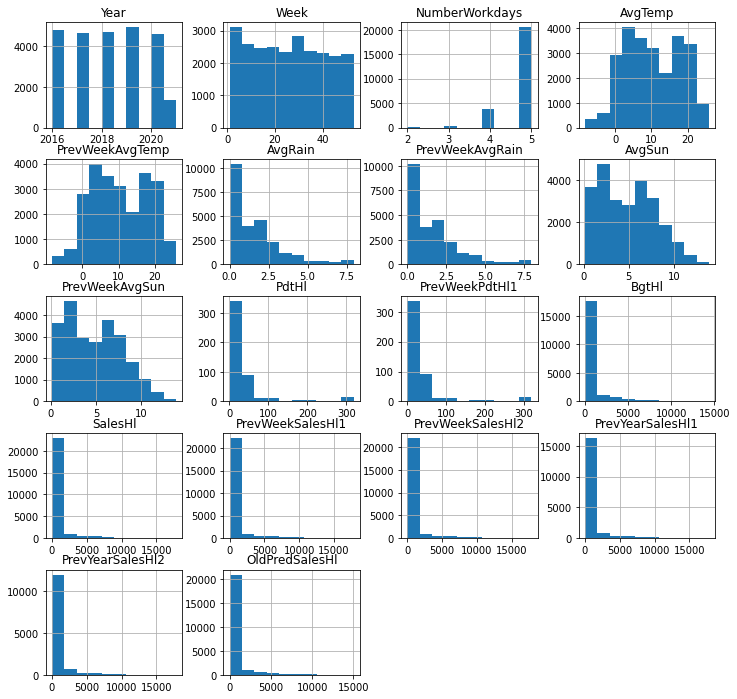

In [281]:
data.hist(figsize=[12,12])
plt.show()

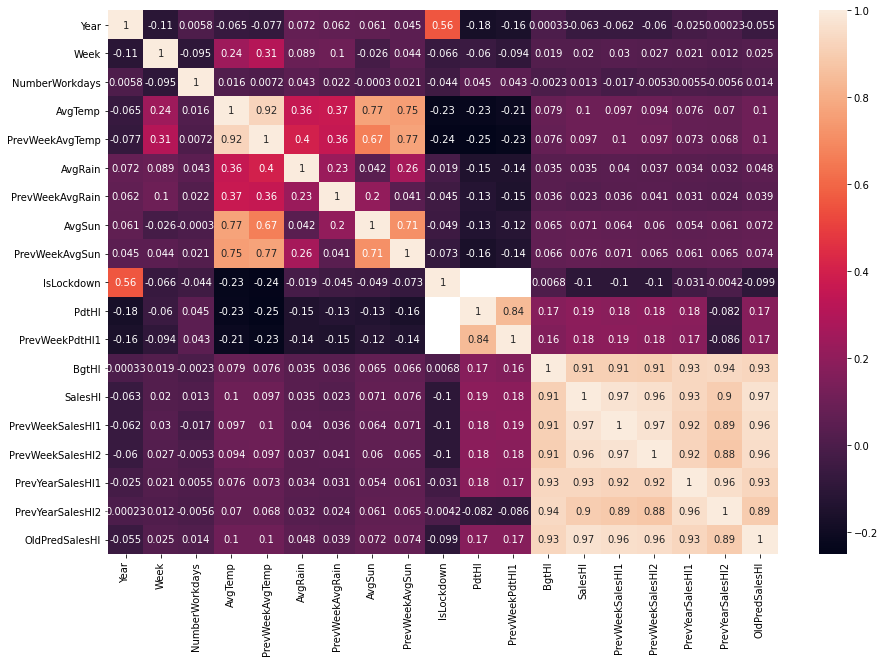

In [282]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

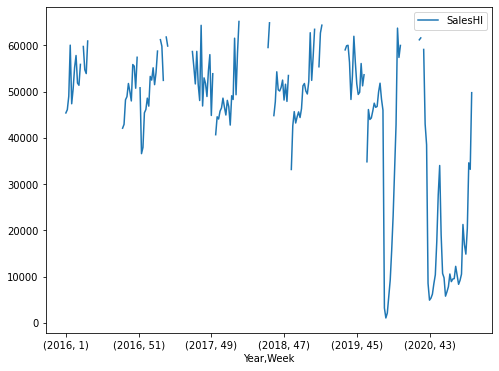

In [283]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

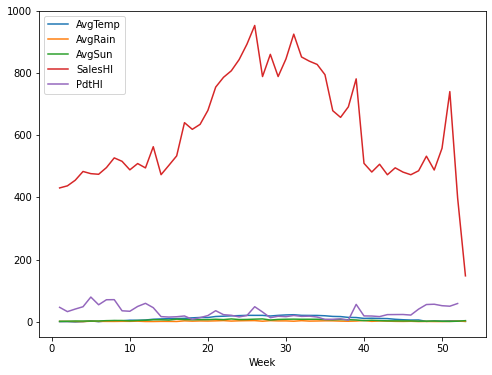

In [284]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

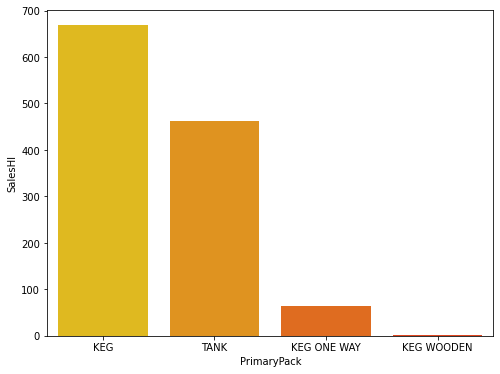

In [285]:
plt.figure(figsize=(8,6))
g_pps = data.groupby('PrimaryPack')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('PrimaryPack')
axis.set_ylabel('SalesHl')

plt.show()

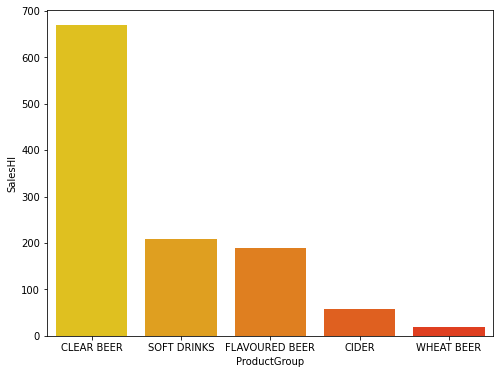

In [286]:
plt.figure(figsize=(8,6))
g_pgs = data.groupby('ProductGroup')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pgs.index, y=g_pgs, palette='autumn_r')
axis.set_xlabel('ProductGroup')
axis.set_ylabel('SalesHl')
plt.show()

In [287]:
# ordinals = ['Week','NumberWorkdays','AvgTemp','AvgRain','AvgSun','PdtHl','BgtHl','PrevWeekSalesHl1','PrevYearSalesHl1']

# fig, ax = plt.subplots(3, 5, figsize=(15, 10))
# fig.tight_layout()
# ax = iter(ax.flatten())
# for feat in ordinals:
#     dataplot = data[[feat, 'SalesHl']]
#     sns.boxplot(x=feat, y='SalesHl', data=dataplot, ax=next(ax))

In [288]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
PrevWeekSalesHl1,0.972611
OldPredSalesHl,0.970593
PrevWeekSalesHl2,0.963891
PrevYearSalesHl1,0.933978
BgtHl,0.908411
PrevYearSalesHl2,0.901446
PdtHl,0.191080
PrevWeekPdtHl1,0.184820
AvgTemp,0.100092


## Skewness and Kurtesis

In [289]:
data.skew()

SkuShort            1.862407
Year                0.082610
Week                0.063349
NumberWorkdays     -2.652512
AvgTemp            -inf     
PrevWeekAvgTemp    -inf     
AvgRain             inf     
PrevWeekAvgRain     inf     
AvgSun              inf     
PrevWeekAvgSun      inf     
IsLockdown          2.309615
PdtHl               3.574219
PrevWeekPdtHl1      3.556641
BgtHl               inf     
SalesHl             inf     
PrevWeekSalesHl1    inf     
PrevWeekSalesHl2    inf     
PrevYearSalesHl1    inf     
PrevYearSalesHl2    inf     
OldPredSalesHl      inf     
dtype: float64

In [290]:
data.kurt()

SkuShort            4.532806
Year               -1.138291
Week               -1.199664
NumberWorkdays      8.131456
AvgTemp            NaN      
PrevWeekAvgTemp    NaN      
AvgRain            NaN      
PrevWeekAvgRain    NaN      
AvgSun             NaN      
PrevWeekAvgSun     NaN      
IsLockdown          3.334588
PdtHl              NaN      
PrevWeekPdtHl1     NaN      
BgtHl              NaN      
SalesHl            NaN      
PrevWeekSalesHl1   NaN      
PrevWeekSalesHl2   NaN      
PrevYearSalesHl1   NaN      
PrevYearSalesHl2   NaN      
OldPredSalesHl     NaN      
dtype: float64

## Create X, y

In [291]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'ProductGroup', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun' 'BgtHl',

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [292]:
# X['NextWeek'] = X['Week']+1
# X['PrevWeek'] = X['Week']-1

# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

# X = X.drop(['NextWeek', 'PrevWeek', 'WeekPrev', 'WeekNext'], axis=1)
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
# X

## LabelEncoder

In [293]:
# create Temp
# bins = [-np.inf, -1, 1, 10, 15, 20, np.inf]
# names = ['mraz', 'kolem nuly', 'chladno', 'teplo', 'velmi teplo', 'horko']
# X['Temp'] = pd.cut(X['AvgTemp'], bins=bins, labels=names)
# X['PrevWeekTemp'] = pd.cut(X['PrevWeekAvgTemp'], bins=bins, labels=names)

# #create Rain
# bins = [0, 0.1, 2.5, 8, 40, np.inf]
# names = ['velmi slabá', 'slabá', 'mírná', 'silná', 'velmi silná']
# X['Rain'] = pd.cut(X['AvgRain'], bins=bins, labels=names)
# X['PrevWeekRain'] = pd.cut(X['PrevWeekAvgRain'], bins=bins, labels=names)

# #create Sun
# bins = [0, 2, 5, 8, np.inf]
# names = ['zatazeno', 'oblacno', 'polojasno', 'jasno']
# X['Sun'] = pd.cut(X['AvgSun'], bins=bins, labels=names)
# X['PrevWeekSun'] = pd.cut(X['PrevWeekAvgSun'], bins=bins, labels=names)

# X.Rain = LabelEncoder().fit_transform(X.Rain)
# X.Temp = LabelEncoder().fit_transform(X.Temp)
# X.Sun = LabelEncoder().fit_transform(X.Sun)
# X.PrevWeekTemp = LabelEncoder().fit_transform(X.PrevWeekTemp)
# X.PrevWeekRain = LabelEncoder().fit_transform(X.PrevWeekRain)
# X.PrevWeekSun = LabelEncoder().fit_transform(X.PrevWeekSun)

# X = X.drop(['AvgTemp', 'AvgRain', 'AvgSun', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'], axis=1)

#round weather
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

In [294]:
Country_mapping = {"CZ": 1, "SK": 2}
PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

el = LabelEncoder()
X.SkuShort = el.fit_transform(X.SkuShort)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,5,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1902.00000,NaN,NaN,NaN,NaN
1,1,2,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,473.00000,NaN,NaN,NaN,NaN
2,2,2,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,3010.00000,NaN,NaN,NaN,NaN
3,3,2,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,4932.00000,NaN,NaN,NaN,NaN
4,5,7,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,46.15625,NaN,NaN,NaN,NaN


## Imputer

In [295]:
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [296]:
si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)

si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Adding a New Feature

In [297]:
#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

# X['SalesPerPdt'] = X['PrevWeekSalesHl1'].divide(X['PrevWeekPdtHl1'], fill_value=0) #dataset['PrevWeekSalesHl1'] / dataset['PrevWeekPdtHl1']
# X['SalesPerPdt'] = X['SalesPerPdt'].replace([np.inf, -np.inf, np.nan], 0)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,5.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,1902.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
1,1.0,2.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,473.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
2,2.0,2.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,3010.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
3,3.0,2.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,4932.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
4,5.0,7.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,46.15625,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9


In [298]:
X.tail()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
24997,84.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,757.499287,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
24998,86.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,34.343750,13.500000,11.398438,2.099609,16.953125,12.4,9.5,11.0
24999,102.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,72.125000,28.656250,21.296875,9.898438,24.593750,25.0,17.2,21.1
25000,103.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,757.499287,259.500000,180.250000,60.000000,289.250000,219.9,174.6,197.2
25001,118.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,360.750000,243.000000,160.500000,87.000000,284.000000,201.8,185.5,193.6


## Split train, test

In [299]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)

#X = X.drop(['Year'], axis=1)
# X['Year'] = (X['Year']-1900).astype(int)
 
X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
24265,0.0,5.0,1.0,2021.0,10.0,5.0,2.339844,0.876953,3.382812,1.0,0.0,0.0,2440.000000,155.125,215.125,2566.0,2684.00,185.1,2625.0,1405.1
24266,1.0,2.0,1.0,2021.0,10.0,5.0,2.339844,0.876953,3.382812,1.0,0.0,0.0,757.499287,712.000,807.000,512.0,486.25,759.5,499.1,629.3
24267,2.0,2.0,1.0,2021.0,10.0,5.0,2.339844,0.876953,3.382812,1.0,0.0,0.0,2704.000000,1123.000,1506.000,2692.0,2882.00,1314.5,2787.0,2050.8
24268,3.0,2.0,1.0,2021.0,10.0,5.0,2.339844,0.876953,3.382812,1.0,0.0,0.0,5404.000000,1252.000,1561.000,6704.0,6308.00,1406.5,6506.0,3956.2
24269,13.0,2.0,1.0,2021.0,10.0,5.0,2.339844,0.876953,3.382812,1.0,0.0,0.0,757.499287,96.625,114.625,329.5,340.75,105.6,335.1,220.4


## Scaler

In [300]:
#scaler = MinMaxScaler() #0.8361
#scaler = MaxAbsScaler() #0.8335
scaler = StandardScaler() #0.8381
#scaler = RobustScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# y_train = np.log1p(y_train)
# X_test = np.log1p(X_test)

## Regressor

In [301]:
# rf_params = {
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [50, 100, 200, 250, 300]
# }

# xgb_params = {
#     'learning_rate': [0.2],
#     'max_depth': [7, 6, 5, 4, 3],
#     'min_child_weight': [2],
#     'colsample_bytree': [0.5],
#     # 'n_estimators': [100, 200, 300, 400, 500]
# }

# model = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=3)
# # 0.8330057053938816
# # {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1}

# #param_grid = dict(booster=['gbtree', 'gblinear', 'dart'], disable_default_eval_metric=[True, False])
# clf = GridSearchCV(model, xgb_params, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)


# {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.10000000149011612, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 64}

In [302]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
# model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
# model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
# model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049




# hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
# mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
#rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=4)


# xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# # lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)
# model = LGBMRegressor() #0.8059

# model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)#0.8467


# def baseline_model():
#     model = Sequential()
#     model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model


# model = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)


# model = XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=1)


# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829 (0.6246), 0.8377 (0.8027)
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8686 (0.8584), 0.8561 (0.8597)
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418


# 0.7804

In [303]:
#asdfasd

### HistGradientBoostingRegressor 

In [304]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

### MLPRegressor

In [305]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [306]:
rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, max_depth=None, max_features=None, bootstrap=True, criterion='mse', oob_score=True, n_jobs=2)

### XGBRegressor

In [307]:
xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=4)

### CatBoostRegressor

In [308]:
cbModel = CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [309]:
lgbmModel = LGBMRegressor(n_jobs=3)

In [310]:
#lModel = linear_model.Lasso(random_state=0, selection='random')

In [311]:
#ardModel = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False)

In [312]:
# brModel = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

In [313]:
# gbrModel = ensemble.GradientBoostingRegressor()

In [314]:
# knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)

In [315]:
# lsvrModel = svm.LinearSVR()

In [316]:
# lrModel = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)

### Use models

In [317]:
# LGBMRegressor
# CatBoostRegressor
# HistGradientBoostingRegressor
# GradientBoostingRegressor

regression_models = [lgbmModel, cbModel, hgbModel, rfModel, xgbModel]
regression_models

[LGBMRegressor(n_jobs=3),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=350, max_leaf_nodes=70, random_state=0),
 RandomForestRegressor(max_features=None, n_estimators=1000, n_jobs=2,
                       oob_score=True, random_state=0),
 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=0.0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method='approx', validate_parameters=None,
              verbosity=None)]

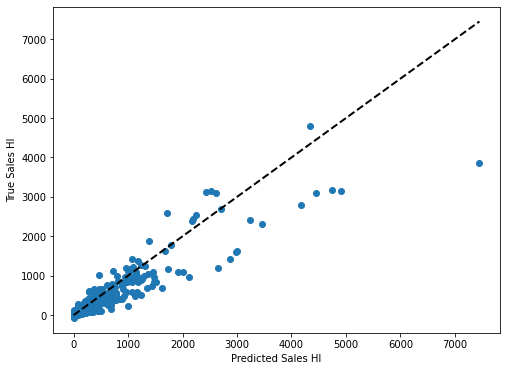

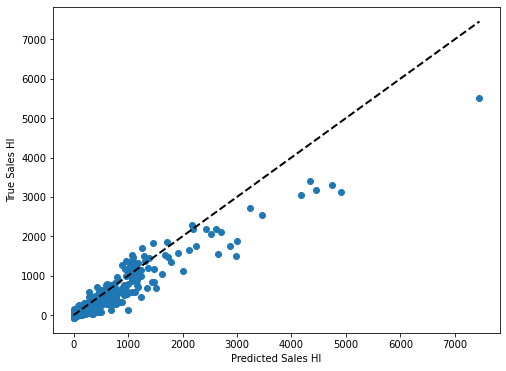

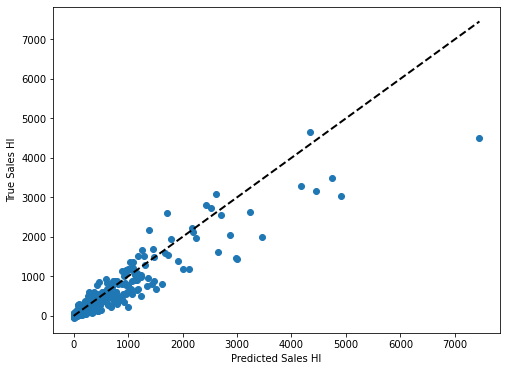

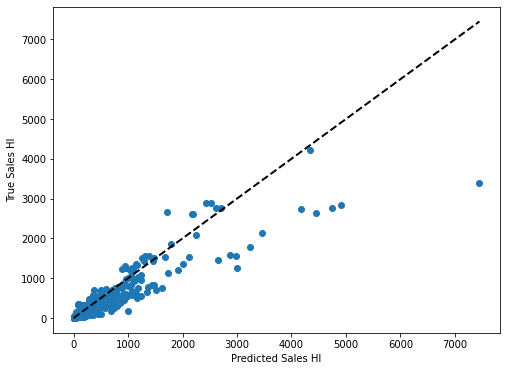

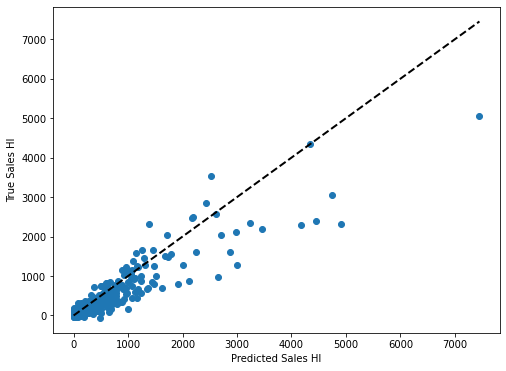

In [318]:
estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train.values.ravel())
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, me, mse, mae]

    estimators.append((model_name, reg_model))

    show_pred(y_test, y_pred)

In [319]:
result_models["Weights"] = result_models['Score'].map(lambda x: round(x, 2))
result_models.sort_values(by=['Score'], ascending=False)


#off-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 6	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 0	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 9	GradientBoostingRegressor	0.843769	391493.638902	391493.638902	264.494670	0.84
# 4	MLPRegressor	0.839527	402124.902408	402124.902408	278.039271	0.84
# 12	LinearRegression	0.832977	418538.501574	418538.501574	308.129606	0.83
# 5	Lasso	0.832871	418803.072085	418803.072085	307.357371	0.83
# 7	ARDRegression	0.832818	418936.806781	418936.806781	307.672709	0.83
# 8	BayesianRidge	0.832793	418999.803428	418999.803428	308.173667	0.83
# 11	LinearSVR	0.829922	426193.915922	426193.915922	270.611320	0.83
# 10	KNeighborsRegressor	0.805067	488476.376995	488476.376995	305.001409	0.81
# 1	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8639

# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 3	GradientBoostingRegressor	0.844420	389862.886930	389862.886930	264.334610	0.84
# 0.8668


# 	Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 4	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8658

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.877972	4499.615238	305751.570936	243.381841	0.88
# 1	CatBoostRegressor	0.868797	4848.307931	328742.181746	254.856241	0.87
# 3	RandomForestRegressor	0.866066	4634.582000	335582.718416	245.259708	0.87
# 2	HistGradientBoostingRegressor	0.859194	4445.449309	352803.126808	255.968944	0.86
# 4	XGBRegressor	0.846541	5841.459961	384504.761200	266.124551	0.85
#0.8755

#on-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 6	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 0	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 9	GradientBoostingRegressor	0.842605	67122.924254	67122.924254	106.539311	0.84
# 10	KNeighborsRegressor	0.815448	78704.180046	78704.180046	135.666990	0.82
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 12	LinearRegression	0.811924	80207.259648	80207.259648	170.711040	0.81
# 5	Lasso	0.810957	80619.289766	80619.289766	169.174454	0.81
# 7	ARDRegression	0.810064	81000.421378	81000.421378	170.797118	0.81
# 8	BayesianRidge	0.808762	81555.376370	81555.376370	171.263265	0.81
# 11	LinearSVR	0.791987	88709.547162	88709.547162	123.906669	0.79
# 4	MLPRegressor	0.599296	170884.695195	170884.695195	177.887054	0.60
# 0.8598


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	GradientBoostingRegressor	0.834394	70624.630360	70624.630360	107.111241	0.83
# 0.8747


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 0.8717


# 	Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 4	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
#0.8798

,Model,Score,ME,MSE,MAE,Weights
1,CatBoostRegressor,0.886093,1951.314928,48567.852765,97.326672,0.89
2,HistGradientBoostingRegressor,0.869292,2951.192139,55731.458495,89.914484,0.87
0,LGBMRegressor,0.838248,3581.780052,68968.260265,98.742636,0.84
4,XGBRegressor,0.820312,2580.676025,76615.703155,115.247313,0.82
3,RandomForestRegressor,0.814436,4058.543000,79120.939596,94.600647,0.81


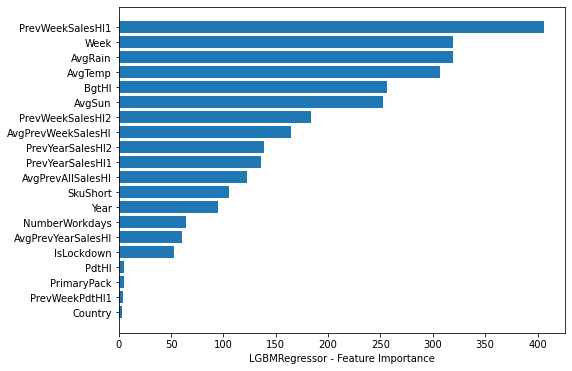

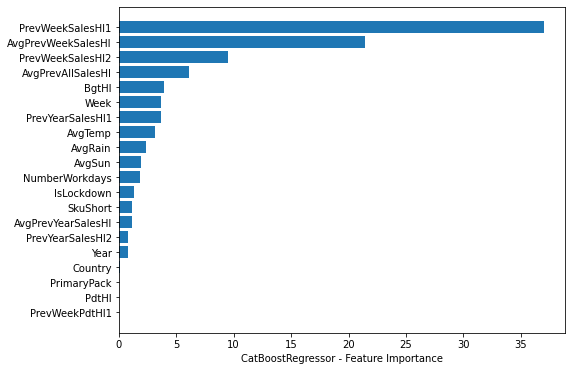

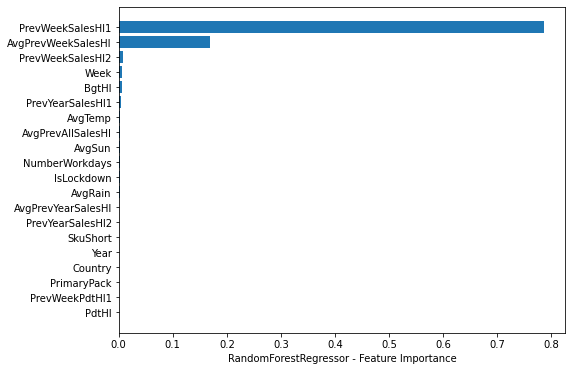

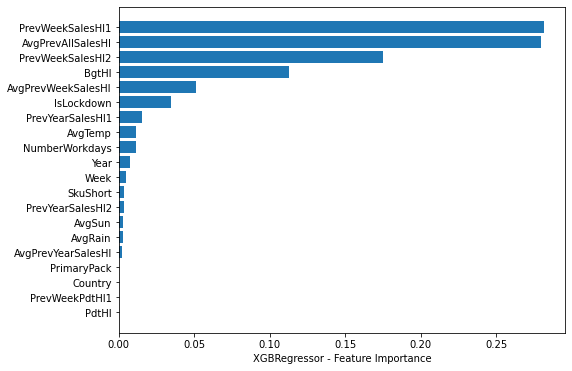

In [320]:
for key, model in estimators:
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(8,6))
        sorted_idx = model.feature_importances_.argsort()
        plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
        plt.xlabel(f"{key} - Feature Importance")
        plt.show()

### VotingRegressor

In [268]:
model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



off-trade
Coefficient of determination: 0.8755
Maximum residual error: 4397.0000
Mean absolute percentage error regression loss: 19563490492678448.0000
Old Coefficient of determination: 0.9544
Old Maximum residual error: 4024.0000
Mean absolute percentage error regression loss: 334373986254886.6875


## Model analysis

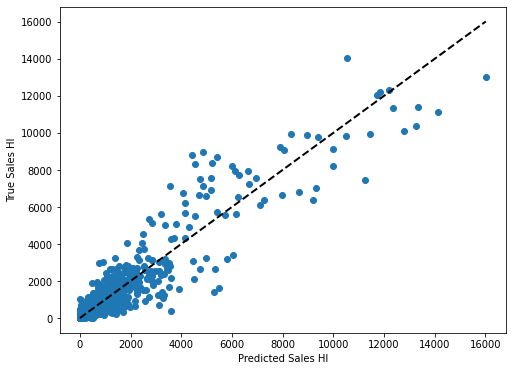

In [269]:
# plt.figure(figsize=(8,6))
# plt.scatter(y_test, y_pred)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# plt.xlabel("Predicted Sales Hl")
# plt.ylabel("True Sales Hl")

# plt.show()

show_pred(y_test, y_pred)

In [270]:
plt.figure(figsize=(8,6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

AttributeError: 'VotingRegressor' object has no attribute 'feature_importances_'

In [430]:
result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10    99.2%          76.2%          -23.0%           
     11    92.7%          98.3%          5.7%             
     12    93.5%          96.7%          3.2%             
     13    57.3%          49.3%          -8.0%            
     14    64.8%          93.6%          28.8%            
     15    86.0%          90.3%          4.2%             
     16    99.3%          75.8%          -23.5%           
     17    94.1%          66.3%          -27.8%           
     18    81.8%          87.9%          6.1%             
     19    73.4%          74.1%          0.7%             
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021  82.6%          82.1%          -0.5%            


In [980]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# X_labels = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_labels)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

exception calling callback for <Future at 0x29f4d15fc10 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\K\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Program Files\Python39\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "sklearn\tree\_tree.pyx", line 671, in sklearn.tree._tree.Tree.__setstate__
  File "sklearn\tree\_tree.pyx", line 705, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 1858024 bytes
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\K\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\_b

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [345]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()
X_labels = X.columns.tolist()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

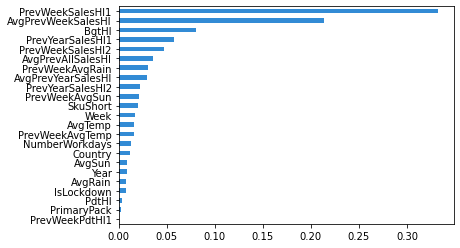

In [346]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [94]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [95]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [96]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [97]:
# shap.plots.force(shap_values[0])

In [98]:
# shap.plots.force(shap_values)

In [99]:
# shap.plots.scatter(shap_values, color=shap_values)

In [100]:
# shap.plots.bar(shap_values)

In [101]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [102]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [103]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [104]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363